In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
def label_encode_features(dataFrame, features, label_encoder = LabelEncoder()):
    for feature in features:
        dataFrame[feature] = label_encoder.fit_transform(dataFrame[feature])
    return dataFrame

def one_hot_encode_features(dataFrame, feature_names, one_hot_encoder = OneHotEncoder(sparse_output=False)):
    for feature in feature_names:
        encoded = one_hot_encoder.fit_transform(dataFrame[feature].values.reshape(-1, 1)).astype(np.int64)
        encoded_df = pd.DataFrame(encoded)
        encoded_df.columns = [feature + '_' + str(i) for i in range(encoded.shape[1])]
        encoded_df.index = dataFrame.index
        dataFrame = dataFrame.drop(feature, axis=1)
        dataFrame = pd.concat([dataFrame, encoded_df], axis=1)
    return dataFrame

def remove_outliers(dataFrame, columns):
    for column in columns:
        # Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(dataFrame[column], 25)
        Q3 = np.percentile(dataFrame[column], 75)
        IQR = Q3 - Q1
        step = 1.5 * IQR
        # Remove the outliers
        dataFrame = dataFrame[(dataFrame[column] >= Q1 - step) & (dataFrame[column] <= Q3 + step)]
    return dataFrame

In [3]:
# import the dataset. the extension is .NAMES
dataset_path = 'datasets/adult/'

data_column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
                     'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
data = pd.read_csv(dataset_path + 'adult.data', names=data_column_names)
data_test = pd.read_csv(dataset_path + 'adult.test', names=data_column_names)
# remove the first row of the test data
data_test = data_test.drop(data_test.index[0])
data_test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
5,18,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.


seems like the data has spaces. a lot of spaces
let's remove them

In [4]:
# remove spaces from the beginning and end of the values
data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# remove the rows with '?' values
data = data[(data != '?').all(axis=1)]
data_test = data_test[(data_test != '?').all(axis=1)]


In [5]:
# see if there are any missing values
for column in data.columns:
    if data[column].isnull().sum() > 0:
        print('There are missing values in column ' + column)

In [6]:
for column in data.columns:
    print(column, '\t', type(data[column].unique()[0]), '\n', data[column].unique(), '\n')

age 	 <class 'numpy.int64'> 
 [39 50 38 53 28 37 49 52 31 42 30 23 32 34 25 43 40 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 47 46 36 79 27 18 33 76 55 61 70 64 71 66 51 58
 26 17 60 90 75 65 77 62 63 67 74 72 69 68 73 81 78 88 80 84 83 85 82 86] 

workclass 	 <class 'str'> 
 ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov'
 'Self-emp-inc' 'Without-pay'] 

fnlwgt 	 <class 'numpy.int64'> 
 [ 77516  83311 215646 ...  84661 257302 201490] 

education 	 <class 'str'> 
 ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 '7th-8th' 'Doctorate' 'Assoc-voc' 'Prof-school' '5th-6th' '10th'
 'Preschool' '12th' '1st-4th'] 

education-num 	 <class 'numpy.int64'> 
 [13  9  7 14  5 10 12  4 16 11 15  3  6  1  8  2] 

marital-status 	 <class 'str'> 
 ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed'] 

occupation 	 <class 'str'> 
 ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-sp

In [7]:
data['native-country'].unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', 'Mexico',
       'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany', 'Iran',
       'Philippines', 'Poland', 'Columbia', 'Cambodia', 'Thailand',
       'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'Italy', 'China', 'South', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

In [8]:
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
one_hot_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
label_features =   ['sex', 'income']

In [9]:
data = label_encode_features(data, label_features)
data_test = label_encode_features(data_test, label_features)
data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [10]:
data['sex']

0        1
1        1
2        1
3        1
4        0
        ..
32556    0
32557    1
32558    0
32559    1
32560    0
Name: sex, Length: 30162, dtype: int32

In [11]:
encoder = OneHotEncoder(sparse=False)
encoded = encoder.fit(data[one_hot_features])
encoded.categories_

C:\Users\Zainal Abedin\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[array(['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc',
        'Self-emp-not-inc', 'State-gov', 'Without-pay'], dtype=object),
 array(['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th',
        'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad',
        'Masters', 'Preschool', 'Prof-school', 'Some-college'],
       dtype=object),
 array(['Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
        'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'],
       dtype=object),
 array(['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial',
        'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct',
        'Other-service', 'Priv-house-serv', 'Prof-specialty',
        'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'],
       dtype=object),
 array(['Husband', 'Not-in-family', 'Other-relative', 'Own-child',
        'Unmarried', 'Wife'], dtype=object),
 array(['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', '

In [12]:
data = pd.get_dummies(data, columns=one_hot_features, drop_first=True, dtype=np.int64)
data_test = pd.get_dummies(data_test, columns=one_hot_features, drop_first=True, dtype=np.int64)

In [13]:
data_test['age'] = pd.to_numeric(data_test['age'])

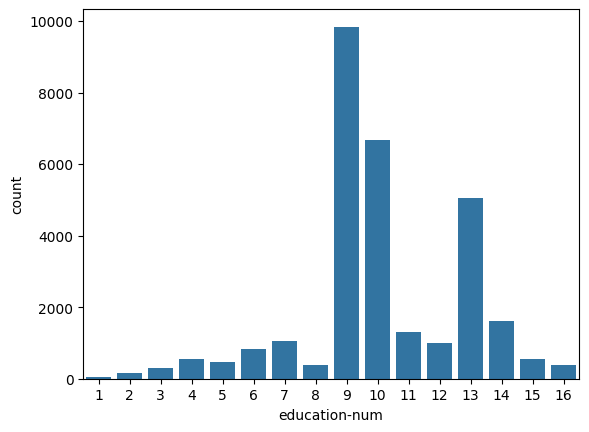

In [14]:
sns.countplot(x='education-num', data=data)
plt.show()

In [15]:
# remove outliers of age column. other columns dont seem to have outliers
data = remove_outliers(data, ['age', 'education-num'])

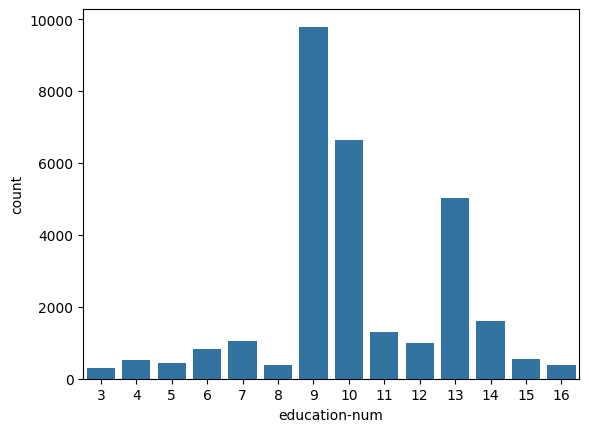

In [16]:
sns.countplot(x='education-num', data=data)
plt.show()

In [17]:
data.shape

(29800, 97)

In [18]:
data['income'].value_counts()

income
0    22327
1     7473
Name: count, dtype: int64

In [19]:
X = data.drop('income', axis=1)
y = pd.DataFrame(data['income'])

In [20]:
non_numeric_columns = data_test.select_dtypes(exclude=['number']).columns
print(non_numeric_columns)


Index([], dtype='object')


In [21]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [22]:
scalar = StandardScaler()
X_train[numeric_features] = scalar.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scalar.transform(X_test[numeric_features])

In [25]:
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

In [27]:
type(X_train)

numpy.ndarray

In [28]:
type(y_train)

numpy.ndarray

In [26]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train.ravel())

y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8406040268456376